# Regression Experiments 2

My previous notebook was getting a little bit messy, so I decided to make this to make the code a little more structured. This notebook includes some convenience functions, which should make the experiments a little more readable.

# Setup:

---

In [59]:
import pandas as pd
import json

rounded_train = pd.read_csv('../data/train_with_rounded_score.csv')
rounded_test = pd.read_csv('../data/test_with_rounded_score.csv')
raw_train = pd.read_csv('../data/train_with_raw_score.csv')
raw_test = pd.read_csv('../data/test_with_raw_score.csv')
fips_map = open('../data/fips_map.json')
fips_map = json.load(fips_map)

In [60]:
# Convenience function to get coordinates from fips code
from functools import lru_cache
@lru_cache(maxsize=10000)
def fips_to_coordinate(fips_code):
    fips_code = str(fips_code)
    if fips_code in fips_map:
        return [fips_map[fips_code]['lat'], fips_map[fips_code]['long']]
    else:
        return [None, None]


In [61]:
#add a lat and long column without dropping the fips column
def interpret_fips(df):
    coords = pd.DataFrame(df['fips'].apply(fips_to_coordinate).tolist(), columns=['lat', 'long'])
    df = pd.concat([df, coords], axis=1)
    return df

In [62]:
def add_lag_features(groupbykey:str,shiftcol:str,shiftnum:int,basenum:int,df:pd.DataFrame):
    '''
    This convenience function lags the column by num_weeks after grouping by groupby.
    The base_offset is the number of weeks to ignore before adding lag. For example, 
    If you want to lag the most recent week, you would have a base of 0, and a num_weeks of 1.
    If you want to lag only the week before the most recent week, you would have a base of 1, and a num_weeks of 1. 
    '''
    for i in range(basenum+1,shiftnum+1):
        df[f'{shiftcol}_lag_{i}'] = df.groupby([groupbykey])[shiftcol].shift(i)
    return df

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def regression_metric(y_true,y_pred,title:str):

    plt.figure(figsize=(20,10))
    plt.scatter(y_true, y_pred)
    plt.scatter(y_true, y_true)
    plt.title(title+" Predictions vs Actuals")
    plt.legend(['Predicted','Real'])
    plt.xlabel('Real Score')
    plt.ylabel('Predicted Score')
    plt.show()

    # Error metrics
    print("Mean Squared Error: ", mean_squared_error(y_true, y_pred))
    print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))
    print("R2 Score: ", r2_score(y_true, y_pred))


In [64]:
def shift_target(df:pd.DataFrame, num_weeks:int, target_col:str, groupy:str)->pd.DataFrame:
    df[target_col] = df.groupby([groupy])[target_col].shift(-num_weeks)
    return df

# Experiments:

---

### Basic Catboost Regressor with default parameters, score lag of 4 weeks.

---

In [65]:
train2 = raw_train.copy()
test2 = raw_test.copy()

In [66]:
train2 = interpret_fips(train2)
test2 = interpret_fips(test2)
train2.set_index('date',inplace=True)
test2.set_index('date',inplace=True)
train2 = add_lag_features('fips','score',4,0,train2)
test2 = add_lag_features('fips','score',4,0,test2)

In [67]:
NUM_WEEKS_TO_FORECAST = 1

In [68]:
train2 = shift_target(train2, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
test2 = shift_target(test2, NUM_WEEKS_TO_FORECAST, 'score', 'fips')

In [69]:
train2.drop(['fips'],axis=1,inplace=True)
test2.drop(['fips'],axis=1,inplace=True)
train2.dropna(inplace=True)
test2.dropna(inplace=True)

In [70]:
from catboost import CatBoostRegressor

model2 = CatBoostRegressor()

model2.fit(train2.drop(['score'],axis=1),train2['score'], verbose=False)

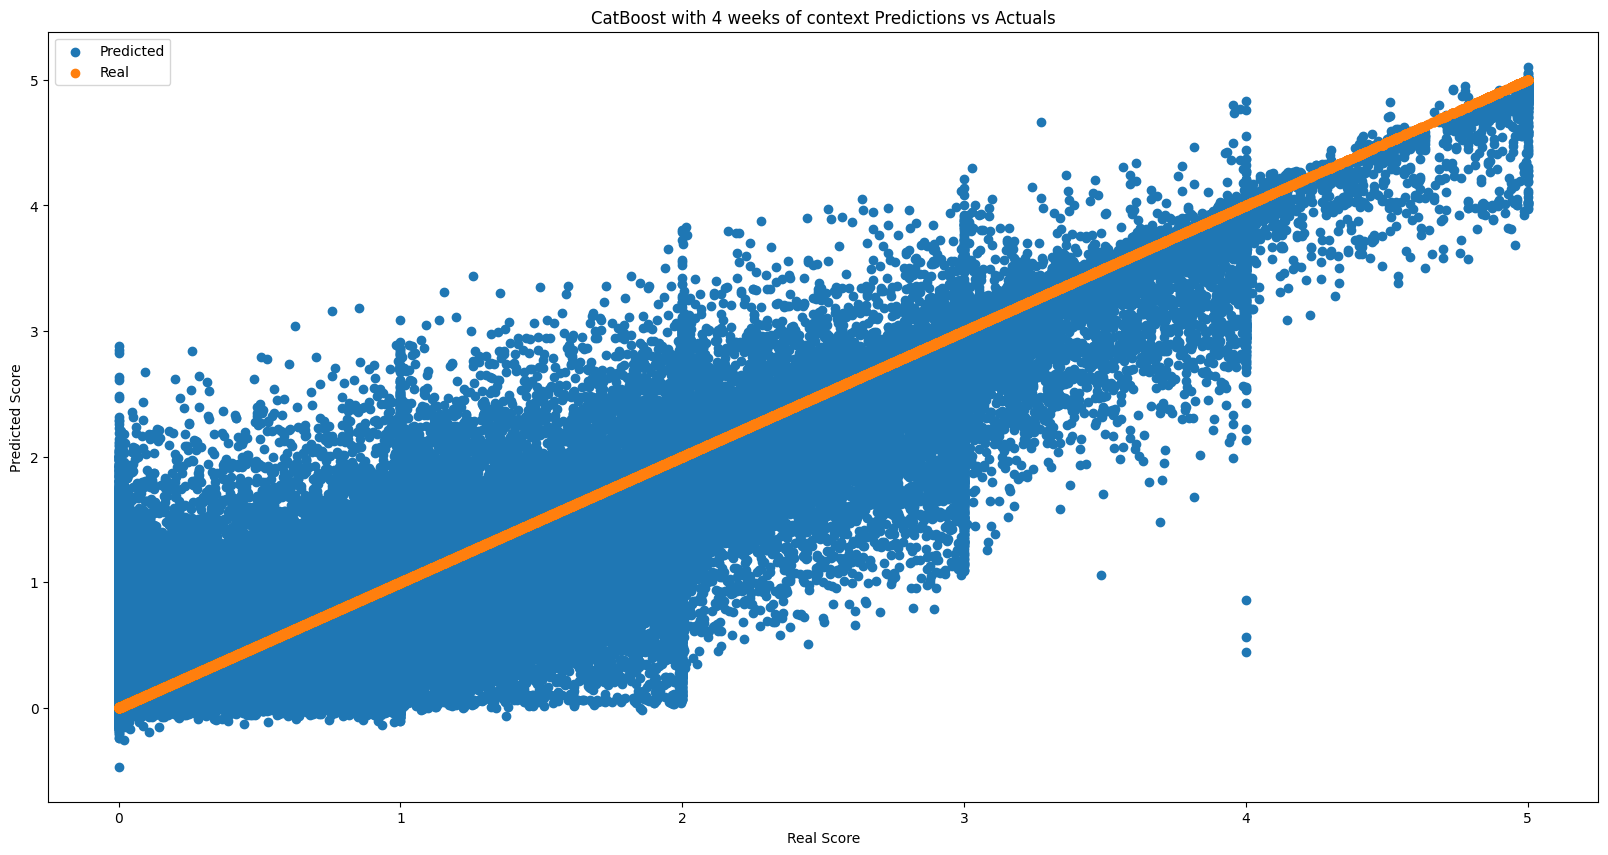

Mean Squared Error:  0.10298512832055014
Mean Absolute Error:  0.17302552702864524
Mean Absolute Percentage Error:  246714846078534.28
R2 Score:  0.8554472329258824


In [71]:
model2_preds = model2.predict(test2.drop(['score'],axis=1))

regression_metric(test2['score'], model2_preds, 'CatBoost with 4 weeks of context')